Cascaded integrator–comb (CIC) 滤波器。由多个积分和梳状滤波器级联构成。在信号处理中,一般用在降采样或者插值过程中。  

积分器的形式为:  
   $$ Y_n = Y_{n-1}+X_n \hspace{20cm}$$  
梳状滤波器形式为:  
   $$ Y_n = X_n + \alpha *X_{n-k} \hspace{20cm}$$  


In [1]:
import numpy as np
from matplotlib import pyplot as plt

N_FFT=8192
_=np.seterr(divide = 'ignore') 


Comb-Filter     $ Y_n = X_n +\alpha X_{n-k} $ 的频率响应类似于梳子  

频率响应为： $Y_z=(1+\alpha Z^{-k})X_z$




Text(0.5, 1.0, 'alpha=1,k=5')

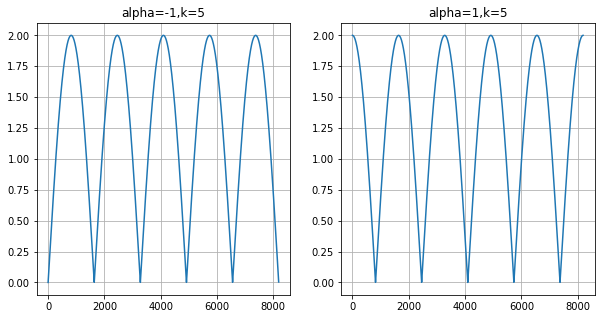

In [2]:
b=np.zeros(N_FFT)
b[0]=1
b[5]=-1
amp=np.fft.fft(b,N_FFT)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.abs(amp))
plt.grid()
plt.title('alpha=-1,k=5')
b[5]=1
amp=np.fft.fft(b,N_FFT)
plt.subplot(1,2,2)
plt.plot(np.abs(amp))
plt.grid()
plt.title('alpha=1,k=5')

一级的CIC,相当于移动平均系统。

时域看
$$ 
\begin{aligned}
Y_n &=\frac 1 k ( X_n+X_{n-1}+...+ X_{n-k+1} )   \hspace{12cm}\\
  &= \frac 1 k (\sum _{i=0}^n X_i - \sum _{i=0}^{n-k} X_i) \\
  &= \sum _{i=0}^{n-k} \frac 1 k ( X _i -X _{k+i})  + Y_0  \\
  &= Y _{n-1} + \frac 1 k  ( X _n -X _{n-k})    
\end {aligned}       
$$

* 公式第2行是先积分后微分,从这个公式看，在输出进行降采样的情况下,每隔K个周期输出一个数据，只依赖间隔K周期的输出，所以不需要保存中间的数据。  
* 公式第4行是先微分后积分  

频域看

 $$
 \begin{aligned}
   Y_z&=X_z\frac 1 k\sum _{i=0} ^ {k-1} z^{-i} \hspace{12cm} \\
    &=X_z\frac 1 k\frac {1-z^{-k} } { 1-z^{-1}} \\
   Y_n-Y_{n-1} &=\frac 1 k ( X_n-X_{n-k})
\end {aligned}      
  $$



如果直接计算移动平均，则需要K个加法操作。 采用先积分再梳状的方法，则需要两个加法（一次积分，一次梳状）,和k个存储单元。用于K倍抽取,则只需要用一个存储单元。  

# 数值溢出
  积分器对所有数据进行累加，如果存在直流分量，就会溢出。不过，这并不影响结果正确性。 因为接下来的梳状滤波器会进行减法,数据就正确了。CIC的的运算都是模n的运算。n为大于k个数据的最小2的次方的数。

  





Text(0.5, 1.0, 'k=140')

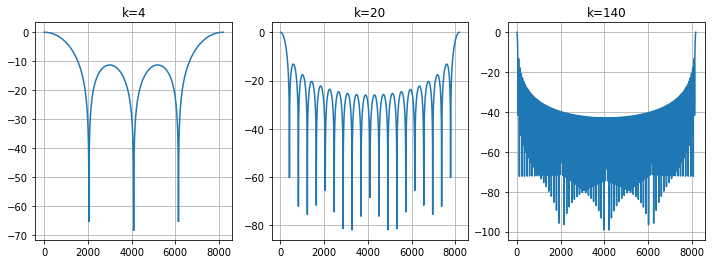

In [3]:


plt.figure(figsize=(12,4))
K=4
b=np.zeros(N_FFT)
b[0:K]=1/K
amp=np.fft.fft(b,N_FFT)

plt.subplot(1,3,1)
plt.plot(20*np.log10(np.abs(amp)))
plt.grid()
plt.title(f"k={K}")

K=20
b[0:K]=1/K
amp=np.fft.fft(b,N_FFT)
plt.subplot(1,3,2)
plt.plot(20*np.log10(np.abs(amp)))
plt.grid()
plt.title(f"k={K}")

K=140
b[0:K]=1/K
amp=np.fft.fft(b,N_FFT)
plt.subplot(1,3,3)
plt.plot(20*np.log10(np.abs(amp)))
plt.grid()
plt.title(f"k={K}")

CIC的频谱图发现，CIC的通带随K的增加而减少,不过第一旁瓣的增益固定不变。简单的增加K,滤波效果增加并不快。  


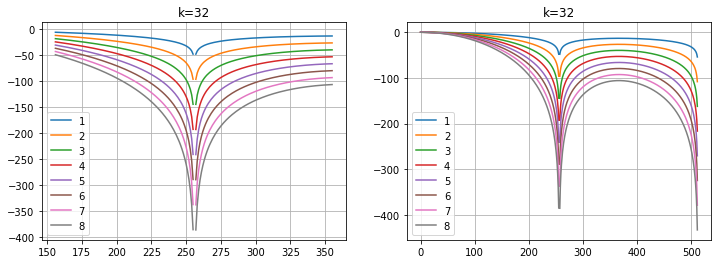

In [7]:
plt.figure(figsize=(12,4))
K=32
N_CASCADED=8
b=np.zeros(N_FFT)
b[0:K]=1/K
amp=np.fft.fft(b,N_FFT)
amp2=np.fft.fft(b,N_FFT)
x= np.linspace(N_FFT//K-100,N_FFT//K+100-1,200)
plt.subplot(1,2,1)
lgends = []
for i in range(N_CASCADED):
    ydb=20*np.log10(np.abs(amp))
    amp=amp*amp2
    plt.plot(x,ydb[N_FFT//K-100:N_FFT//K+100])
    lgends.append(str(i+1))
plt.grid()
plt.title(f"k={K}")
plt.legend(lgends)
plt.subplot(1,2,2)
amp2=np.fft.fft(b,N_FFT)
amp=np.fft.fft(b,N_FFT)
lgends = []
for i in range(N_CASCADED):
    ydb=20*np.log10(np.abs(amp))
    amp=amp*amp2
    plt.plot(ydb[0:N_FFT*2//K])
    lgends.append(str(i+1))
plt.grid()
plt.title(f"k={K}")
plt.legend(lgends)


不过级联多个CIC,增益比较大。CIC级联,频率响应都是线性变化。增益变化很大。

从系统的响应函数 $ H(z)=\frac {Y(z)} {X(z)} $ 来看,多个系统级联等于他们的传递函数相乘，改变级联的顺序不影响最后的结果。  对于 $ H(z) = \frac {Y(z)} {X(z)} =  \frac {1-z^{-k}} { 1-z^{-1}} $ 可以看成两个系统：积分 $ \frac 1 {1-z^{-1}} $ ,差分 $1-z^{-k}$ 的级联 。交换他们的顺序，就可以得到两种形式。   
对于多级的形式,可以按照差分和积分分组也有先积分或者先差分两种形式。

对于抽取时，采用先积分后差分的形式。对于差分阶段，因为要进行K值抽取，而产生这个输出的仅仅依赖当前值以及K个周期之前的值。所以可以将抽取提前，将差分步长改成1.
